In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATA_DIR = "C:/Users/Yakina/.cache/kagglehub/datasets/mdwaquarazam/agricultural-crops-image-classification/versions/1/Agricultural-crops"

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
# Dataset and dataloaders
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

In [5]:
# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define a simple CNN class
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Initialize model
num_classes = len(dataset.classes)
model = SimpleCNN(num_classes)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

SimpleCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=256, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=256, out_features=30, bias=True)
  )
)

In [11]:
EPOCHS = 50
train_loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total

    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1/50, Loss: 3.4046, Accuracy: 0.0422
Epoch 2/50, Loss: 3.2280, Accuracy: 0.1056
Epoch 3/50, Loss: 3.1060, Accuracy: 0.1146
Epoch 4/50, Loss: 2.9656, Accuracy: 0.1388
Epoch 5/50, Loss: 2.8024, Accuracy: 0.1976
Epoch 6/50, Loss: 2.6741, Accuracy: 0.2081
Epoch 7/50, Loss: 2.5753, Accuracy: 0.2594
Epoch 8/50, Loss: 2.4114, Accuracy: 0.2926
Epoch 9/50, Loss: 2.3107, Accuracy: 0.3167
Epoch 10/50, Loss: 2.2308, Accuracy: 0.3409
Epoch 11/50, Loss: 2.1027, Accuracy: 0.3741
Epoch 12/50, Loss: 1.9725, Accuracy: 0.4072
Epoch 13/50, Loss: 1.8866, Accuracy: 0.4027
Epoch 14/50, Loss: 1.6590, Accuracy: 0.4932
Epoch 15/50, Loss: 1.6369, Accuracy: 0.4887
Epoch 16/50, Loss: 1.6464, Accuracy: 0.4962
Epoch 17/50, Loss: 1.5102, Accuracy: 0.5339
Epoch 18/50, Loss: 1.3759, Accuracy: 0.5807
Epoch 19/50, Loss: 1.3108, Accuracy: 0.6139
Epoch 20/50, Loss: 1.1770, Accuracy: 0.6320
Epoch 21/50, Loss: 1.1418, Accuracy: 0.6244
Epoch 22/50, Loss: 1.0021, Accuracy: 0.6802
Epoch 23/50, Loss: 0.9221, Accuracy: 0.69

In [12]:
# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [13]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))


Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.56      0.56      0.56         9
       Coffee-plant       0.00      0.00      0.00         3
           Cucumber       0.00      0.00      0.00         6
   Fox_nut(Makhana)       0.00      0.00      0.00         3
              Lemon       0.33      0.50      0.40         4
         Olive-tree       0.45      1.00      0.62         5
Pearl_millet(bajra)       0.57      0.80      0.67         5
      Tobacco-plant       0.22      0.29      0.25         7
             almond       0.00      0.00      0.00         4
             banana       0.33      0.22      0.27         9
           cardamom       0.40      0.50      0.44         4
             chilli       0.50      0.10      0.17        10
              clove       0.50      0.33      0.40         6
            coconut       0.40      0.40      0.40         5
             cotton       0.43      0.60      0.50         5

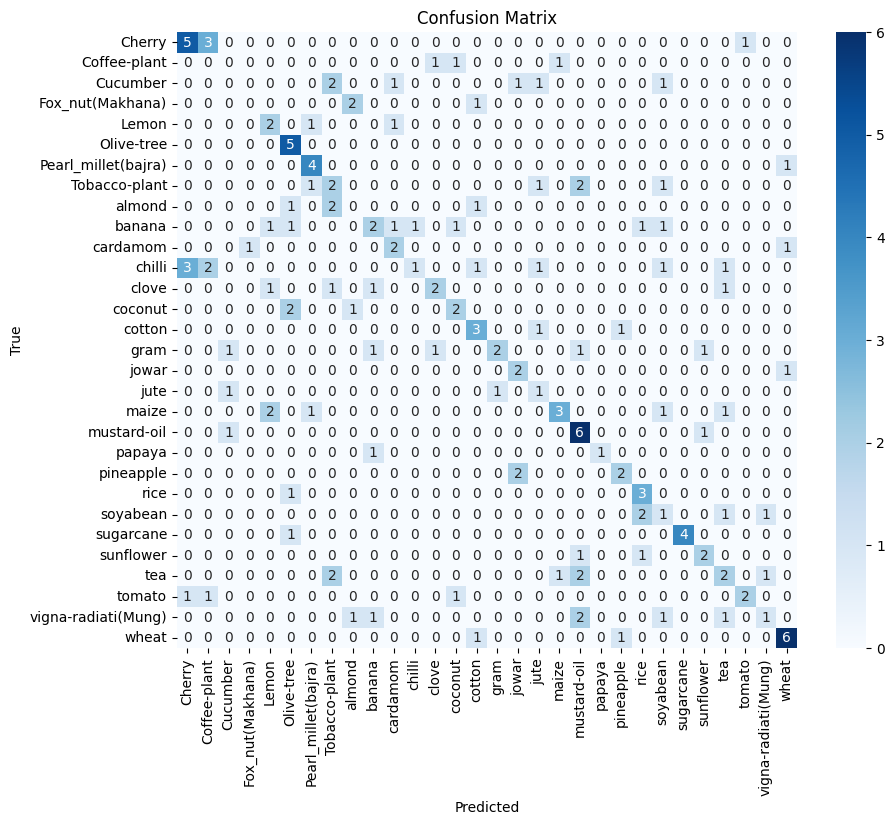

In [14]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

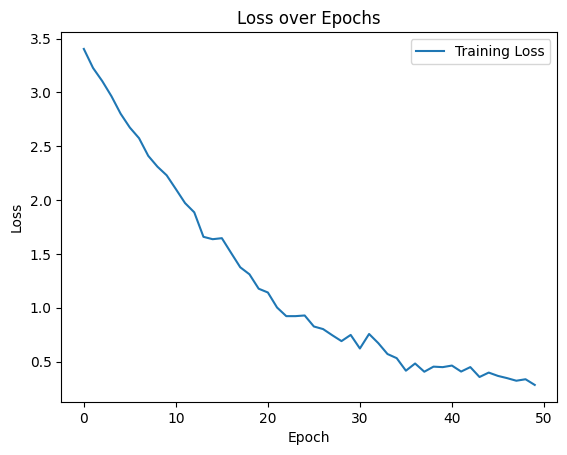

In [15]:
# Loss visualization
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

In [16]:
torch.save(model, 'img_classification_no_tl.pth')